# 面部情感识别

## FER-2013数据集

在此处，我们采用kaggle上的FER-2013数据集。FER-2013数据由48x48 像素的人脸灰度图像组成。 人脸已自动分为七种表情（0=愤怒，1=厌恶，2=恐惧，3=快乐，4=悲伤，5=惊讶，6=中性），因此人脸或多或少居中，并且在每张图像中占据大致相同的空间。训练集包含 28,709 个示例，测试集包含 3,589 个示例。

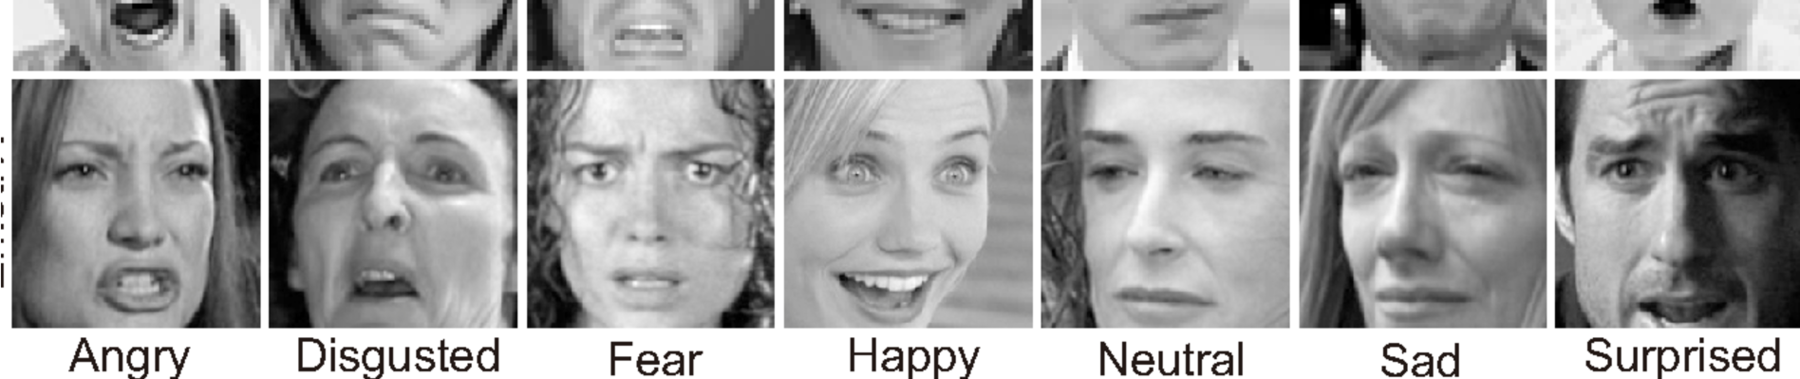

这个数据集来自于2013年的一个比赛，有兴趣的人，可以去读原始的文章：
> Goodfellow, I. J., Erhan, D., Carrier, P. L., Courville, A., Mirza, M., Hamner, B., ... & Bengio, Y. (2013, November). Challenges in representation learning: A report on three machine learning contests. In International conference on neural information processing (pp. 117-124). Springer, Berlin, Heidelberg.

## 用别人的模型

机器学习的概念虽然很容易理解，实务上最大的困难经常不是观念及知识，而是数据及找到最佳模型所需的时间。因此，如果能够找到别人做好的模型，直接使用，就可以节省下大量的时间。

此处我们用的模型及代码，参考Github上的一篇分享: https://github.com/saranshbht/Emotion-detection




## 環境準備

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings('ignore')

### 載入現有的模型

In [2]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

#load trained model
model.load_weights('./model/others_trained_model.h5')

# prevents openCL usage and unnecessary logging messages
cv2.ocl.setUseOpenCL(False)

# dictionary mapping class labels with corresponding emotions
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

### 測試情緒識別

<div><img src="./data/example/LIU.jpg" width="200"/></div>

In [3]:
input_image = cv2.imread('./data/example/LIU.jpg',cv2.IMREAD_COLOR) #将档读入成彩色的
gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY) #因为我们的模型是用灰阶训练的所以必须转成灰阶 
cropped_img = np.expand_dims(np.expand_dims(cv2.resize(gray, (48, 48)), -1), 0)
prediction = model.predict(cropped_img)
maxindex = int(np.argmax(prediction))
print(emotion_dict[maxindex])

1/1 [==============================] - 0s 141ms/step
Neutral


<div><img src="./data/example/minion2.png" width="200"/></div>

In [4]:
input_image = cv2.imread('./data/example/minion2.png',cv2.IMREAD_COLOR) #将档读入成彩色的
gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY) #因为我们的模型是用灰阶训练的所以必须转成灰阶 
cropped_img = np.expand_dims(np.expand_dims(cv2.resize(gray, (48, 48)), -1), 0)
prediction = model.predict(cropped_img)
maxindex = int(np.argmax(prediction))
print(emotion_dict[maxindex])

1/1 [==============================] - 0s 30ms/step
Happy


## 自己训练模型
不想用别人的模型，当然可以自己训练，但是真的很想自己来的人还是必须理解，我们其实还是用别人的模型架构。你如果想连模型架构都自己设计，当然也可以，但是需要更多的时间及资源。此处，我们用别人的架构，来感受一下自己训练模型。
### 先准备画成果的函式

In [5]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    # axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    # axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('./result/training_results.png')
    plt.show()

### 设置模型



In [3]:
train_dir = './data/fer_2013/train'
val_dir = './data/fer_2013/test'
datagen = ImageDataGenerator(rescale=1./255)
num_train = 28709
num_val = 7178
batch_size = 8 #batch_size = 64
num_epoch = 5 # 10
train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### 训练模型

In [4]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
model_info = model.fit(
        train_generator,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=validation_generator,
        validation_steps=num_val // batch_size)
model.save_weights('./model/self_trained_model.h5')
#with open('./model_info/model_info.pkl', 'wb') as file_pi:
#    pickle.dump(model_info.history, file_pi)
#with open('./model_info/model_info.pkl', "rb") as file_pi:
#    model_info = pickle.load(file_pi)

Epoch 1/5
3588/3588 [==============================] - 186s 52ms/step - loss: 0.4889 - accuracy: 0.8191 - val_loss: 1.1784 - val_accuracy: 0.6219
Epoch 2/5
2930/3588 [=======================>......] - ETA: 24s - loss: 0.4695 - accuracy: 0.8314

KeyboardInterrupt: 

### 画出结果及储存结果

In [9]:
plot_model_history(model_info)

: 

: 

### 用新模型预测情绪

In [8]:
input_image = cv2.imread('./data/example/LIU.jpg',cv2.IMREAD_COLOR) #將檔讀入成彩色的
gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY) #因為我們的模型是用灰階訓練的所以必須轉成灰階 
cropped_img = np.expand_dims(np.expand_dims(cv2.resize(gray, (48, 48)), -1), 0)
prediction = model.predict(cropped_img)
maxindex = int(np.argmax(prediction))
print(emotion_dict[maxindex])

1/1 [==============================] - 0s 32ms/step
Neutral


In [9]:
input_image = cv2.imread('./data/example/minion2.png',cv2.IMREAD_COLOR) #将档读入成彩色的
gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY) #因为我们的模型是用灰阶训练的所以必须转成灰阶 
cropped_img = np.expand_dims(np.expand_dims(cv2.resize(gray, (48, 48)), -1), 0)
prediction = model.predict(cropped_img)
maxindex = int(np.argmax(prediction))
print(emotion_dict[maxindex])

1/1 [==============================] - 0s 22ms/step
Happy
